In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
import spectral

## Initial Value Problem

In [2]:
N = 128
x_basis = spectral.Fourier(N)
y_basis = spectral.Chebyshev(N)
domain = spectral.Domain([x_basis, y_basis])
c = spectral.Field(domain)
cy = spectral.Field(domain)
c_RHS = spectral.Field(domain)
cy_RHS = spectral.Field(domain)
x, y = domain.grids()
xm, ym = np.meshgrid(x.ravel(), y.ravel())

dt = 5e-2
s = 1e-3
R = 1

In [3]:
problem = spectral.InitialValueProblem(domain, [c, cy], [c_RHS, cy_RHS], num_BCs=4)

In [4]:
diag = np.arange(N-1) + 1
D = sparse.diags(diag, offsets=1)

diag0 = np.ones(N)/2
diag0[0] = 1
diag2 = -np.ones(N-2)/2
C = sparse.diags((diag0, diag2), offsets=(0, 2))

Z = sparse.csr_matrix((N, N))

In [5]:
for p in problem.pencils:
    n = p.wavenumbers[0]
    
    p.M = sparse.csr_matrix((4*N+4, 4*N+4))
    p.M[2*N:3*N, :N] = C
    p.M[3*N:4*N, N:2*N] = C
    p.M.eliminate_zeros()
    
    L = sparse.bmat([[       D,        Z,   -C,    Z],
                     [       Z,        D,    Z,   -C],
                     [s*n**2*C,        Z, -s*D,    Z],
                     [       Z, s*n**2*C,    Z, -s*D]])
    
    i = np.arange(N)
    BC_rows = np.zeros((4, 4*N))
    BC_rows[0, :N] = (-1)**i
    BC_rows[1, :N] = (+1)**i
    BC_rows[2, N:2*N] = (-1)**i
    BC_rows[3, N:2*N] = (+1)**i
    
    cols = np.zeros((4*N,4))
    cols[  N-1, 0] = 1
    cols[2*N-1, 1] = 1
    cols[3*N-1, 2] = 1
    cols[4*N-1, 3] = 1
    
    corner = np.zeros((4,4))
    
    p.L = sparse.bmat([[L, cols],
                       [BC_rows, corner]])
    
    p.L.eliminate_zeros()
    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [6]:
ts = spectral.SBDF2(problem)

<IPython.core.display.Javascript object>


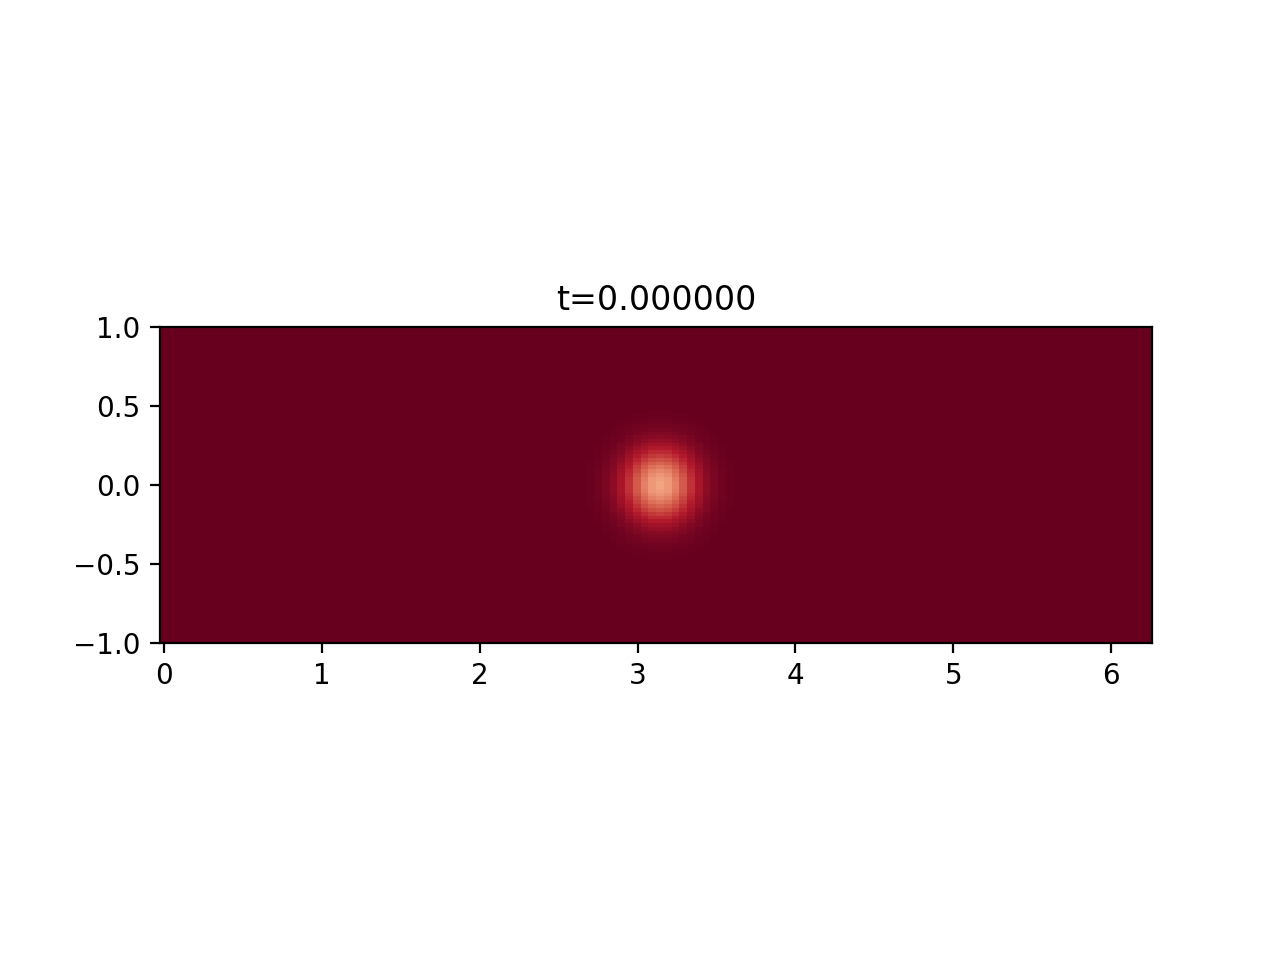

In [7]:
c.require_grid_space()
r = np.sqrt((x-np.pi)**2 + y**2)
c.data = 0.3*np.exp(-20*r**2)

fig = plt.figure()
ax = fig.subplots(1)
ax.pcolormesh(xm, ym, c.data.T, cmap='RdBu', vmax=1)
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %ts.time)

# Where we left off last time

<IPython.core.display.Javascript object>


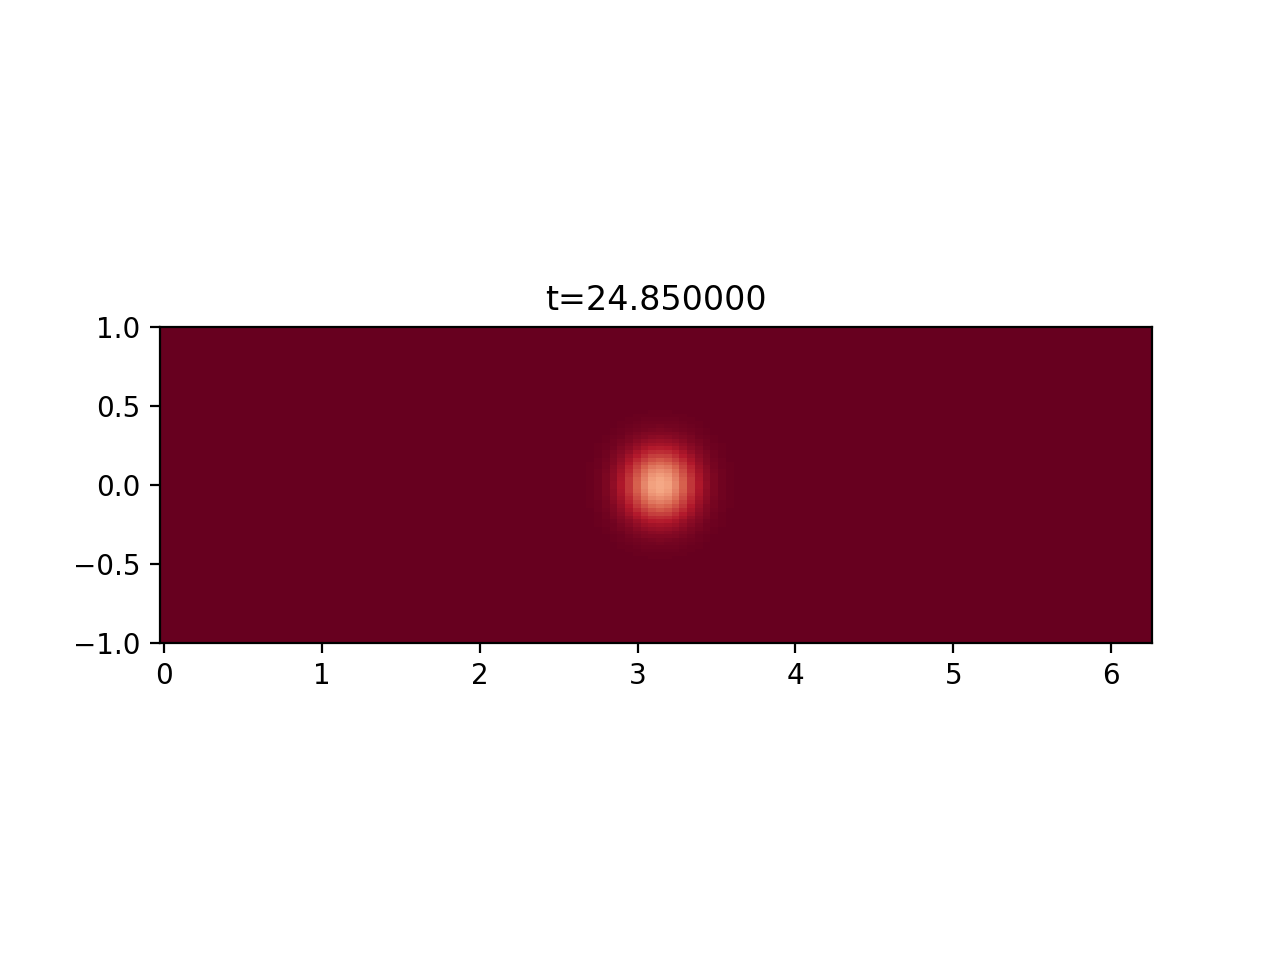

In [9]:
c.require_grid_space()
fig = plt.figure()
ax = fig.subplots(1)
pcm = ax.pcolormesh(xm, ym, c.data.T, cmap='RdBu', vmax=1)
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %ts.time)

def BC_func(wavenumbers):
    return [0,0,0,0]

for i in range(500):
    c.require_grid_space(scales=3/2)
    cy_RHS.require_grid_space(scales=3/2)
    cy_RHS.data = R*c.data*(1-c.data)
    cy_RHS.require_coeff_space()
    
    cy_RHS.data = spectral.apply_matrix(C, cy_RHS.data, axis=1)
    
    ts.step(dt, BC_func)
    
    if i % 5 == 0:
        title.set_text('t=%f' %ts.time)
        c.require_grid_space()
#         pcm.set_array(c.data[:-1,:-1].T.ravel())
        fig.canvas.draw()
        c.require_coeff_space()

<IPython.core.display.Javascript object>


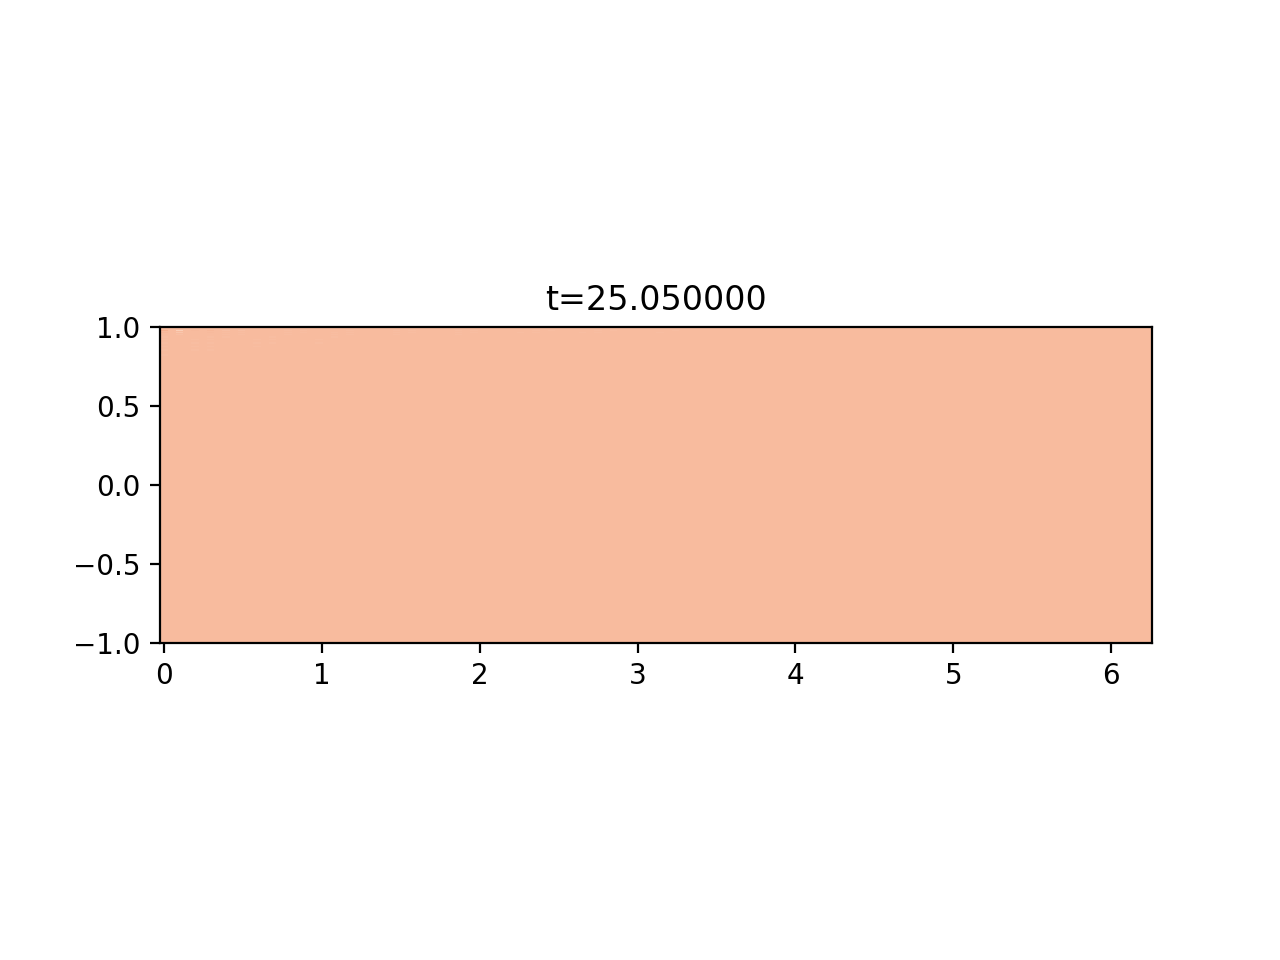

In [10]:
fig = plt.figure()
ax = fig.subplots(1)
ax.pcolormesh(xm, ym, c.data.T, cmap='RdBu', vmax=1)
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %ts.time)

## Eigenvalue Problems

In [62]:
N = 256
x_basis = spectral.Chebyshev(N)
x = x_basis.grid()
domain = spectral.Domain([x_basis])

In [63]:
C = x_basis.convert_TU()
D = x_basis.derivative_TU()
Z = sparse.csr_matrix((N, N))

In [64]:
M = sparse.csr_matrix((2*N+2, 2*N+2))
M[N:2*N, :N] = C

L = sparse.bmat([[D, -C],
                 [Z,  D]])

i = np.arange(N)
BC_rows = np.zeros((2, 2*N))
BC_rows[0, :N] = (-1)**i
BC_rows[1, :N] = (+1)**i

cols = np.zeros((2*N, 2))
cols[  N-1, 0] = 1
cols[2*N-1, 1] = 1

corner = np.zeros((2, 2))

L = sparse.bmat([[L, cols],
                 [BC_rows, corner]])

/opt/miniconda3/envs/dedalus_new/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


<IPython.core.display.Javascript object>


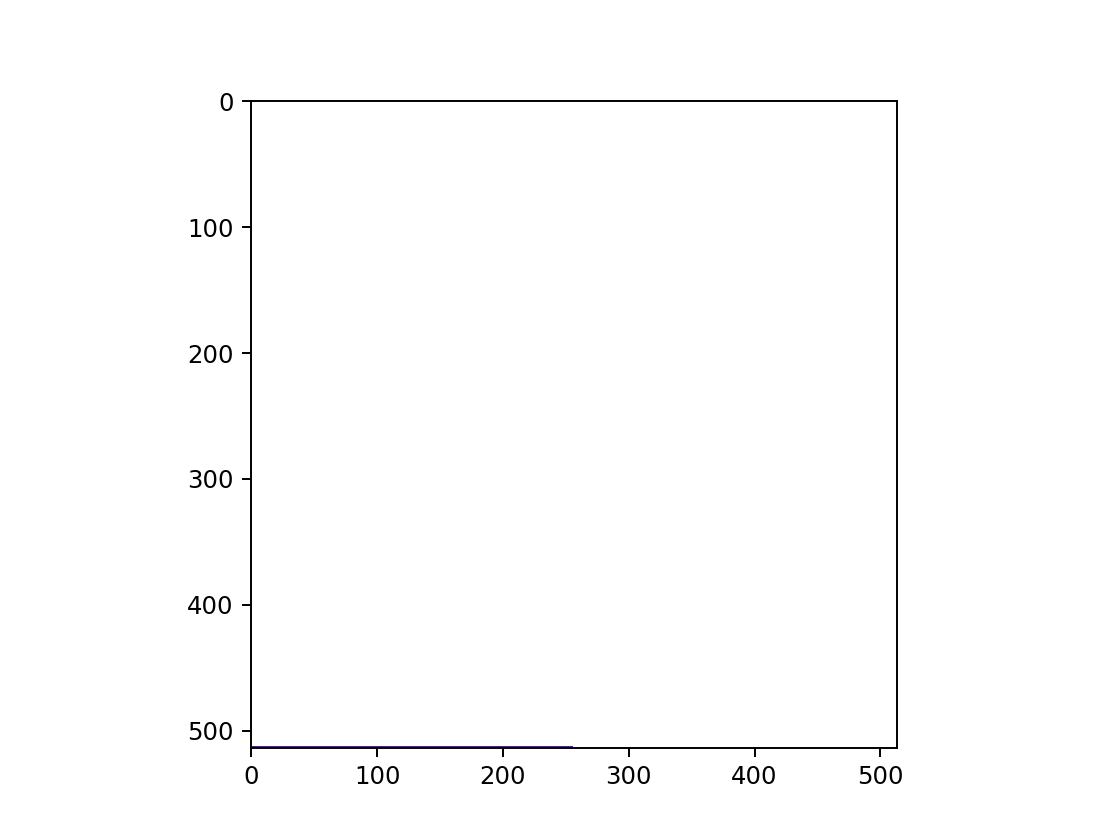

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_13725/1715369409.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(L.A)))


In [65]:
plt.figure()
plt.imshow(np.log(np.abs(L.A)))

Let's do a dense solve to get all the eigenvalues of this problem.

In [66]:
# :(
L = L.A
M = M.A

In [19]:
scipy.linalg.eig?

In [67]:
values, vectors = scipy.linalg.eig(-L, M)

Now we need to filter and order these.

In [68]:
finite = np.isfinite(values)
values = values[finite]
vectors = vectors[:, finite]

In [51]:
values

array([1.27164709e+07+0.j, 2.20701143e+06+0.j, 3.81300744e+06+0.j,
       9.04041165e+05+0.j, 1.43082154e+06+0.j, 4.85699517e+05+0.j,
       6.25092343e+05+0.j, 3.04305091e+05+0.j, 3.88013215e+05+0.j,
       2.08337743e+05+0.j, 2.45419602e+05+0.j, 1.52054281e+05+0.j,
       1.79080668e+05+0.j, 1.15984409e+05+0.j, 1.30856329e+05+0.j,
       9.16418420e+04+0.j, 1.03540405e+05+0.j, 7.43630285e+04+0.j,
       8.17576865e+04+0.j, 6.17141828e+04+0.j, 6.79544101e+04+0.j,
       5.21480786e+04+0.j, 5.63441967e+04+0.j, 4.47654663e+04+0.j,
       4.84259182e+04+0.j, 3.89378102e+04+0.j, 4.15401247e+04+0.j,
       3.42726384e+04+0.j, 3.65913768e+04+0.j, 3.04768839e+04+0.j,
       3.21953590e+04+0.j, 2.73579672e+04+0.j, 2.89089903e+04+0.j,
       2.47651905e+04+0.j, 2.59521512e+04+0.j, 2.25958304e+04+0.j,
       2.36731919e+04+0.j, 2.07670773e+04+0.j, 1.92212344e+04+0.j,
       2.16120252e+04+0.j, 1.79111272e+04+0.j, 1.99858978e+04+0.j,
       1.68017091e+04+0.j, 1.85212368e+04+0.j, 1.58556541e+04+

In [69]:
order = np.argsort(values.real)
values = values[order]
vectors = vectors[:, order]

In [29]:
values

array([2.46740110e+00+0.j, 9.86960440e+00+0.j, 2.22066099e+01+0.j,
       3.94784176e+01+0.j, 6.16850275e+01+0.j, 8.88264396e+01+0.j,
       1.20902654e+02+0.j, 1.57913670e+02+0.j, 1.99859489e+02+0.j,
       2.46740110e+02+0.j, 2.98555553e+02+0.j, 3.55305755e+02+0.j,
       4.16989123e+02+0.j, 4.83610918e+02+0.j, 5.55217042e+02+0.j,
       6.31680188e+02+0.j, 7.12792569e+02+0.j, 8.01545047e+02+0.j,
       9.03487800e+02+0.j, 1.01867037e+03+0.j, 1.16147534e+03+0.j,
       1.37747572e+03+0.j, 1.69076761e+03+0.j, 2.07321307e+03+0.j,
       2.62067937e+03+0.j, 3.69729289e+03+0.j, 5.73722285e+03+0.j,
       8.78066006e+03+0.j, 1.50756916e+04+0.j, 4.98017177e+04+0.j])

In [70]:
om = np.sqrt(values)

In [31]:
om

array([  1.57079633+0.j,   3.14159265+0.j,   4.71238898+0.j,
         6.28318531+0.j,   7.85398163+0.j,   9.42477796+0.j,
        10.99557429+0.j,  12.56637061+0.j,  14.13716694+0.j,
        15.70796327+0.j,  17.27876016+0.j,  18.84955582+0.j,
        20.42031152+0.j,  21.99115545+0.j,  23.56304399+0.j,
        25.13324866+0.j,  26.69817539+0.j,  28.3115709 +0.j,
        30.05807378+0.j,  31.91661591+0.j,  34.0804246 +0.j,
        37.11436004+0.j,  41.11894466+0.j,  45.53254957+0.j,
        51.19257146+0.j,  60.8053689 +0.j,  75.74445756+0.j,
        93.70517629+0.j, 122.78310779+0.j, 223.16298469+0.j])

Eigenfunctions:

In [54]:
vectors.shape

(258, 126)

In [55]:
vector = vectors[:, 2]

In [56]:
u = spectral.Field(domain, dtype=np.complex128)

In [57]:
u.require_coeff_space()
u.data = vector[:N]

In [58]:
u.data

array([-5.11843403e-02,  1.77861744e-16, -5.63399061e-02,  2.18012045e-16,
        1.42636294e-01, -2.16809334e-16, -3.95883733e-02, -2.29063096e-18,
        4.79560842e-03, -7.41779555e-17, -3.34052487e-04, -1.34297311e-17,
        1.52513356e-05, -2.60088050e-17, -4.93644274e-07, -1.16009816e-17,
        1.19435547e-08, -4.49276183e-18, -2.24458403e-10,  7.38476142e-18,
        3.37370316e-12,  1.63981765e-17, -4.14978650e-14,  2.18679256e-17,
        4.05584238e-16,  1.73194424e-18, -6.77023520e-17,  1.52102692e-17,
        1.77796090e-17, -1.49361089e-17, -5.73742360e-17,  7.31753728e-18,
       -2.30687375e-17, -2.00896054e-17,  2.64803007e-17, -7.96323280e-19,
       -4.53037968e-17, -7.67394936e-18,  5.90333046e-17, -2.47705683e-17,
       -8.76172017e-18,  2.18454200e-17, -1.67247970e-17, -1.22844026e-17,
       -9.04407073e-18,  1.00347717e-17, -3.26106418e-18, -4.98181697e-19,
       -2.94599561e-17,  1.74898363e-17, -5.79694514e-18,  3.16511391e-19,
       -2.57246033e-17,  

<IPython.core.display.Javascript object>


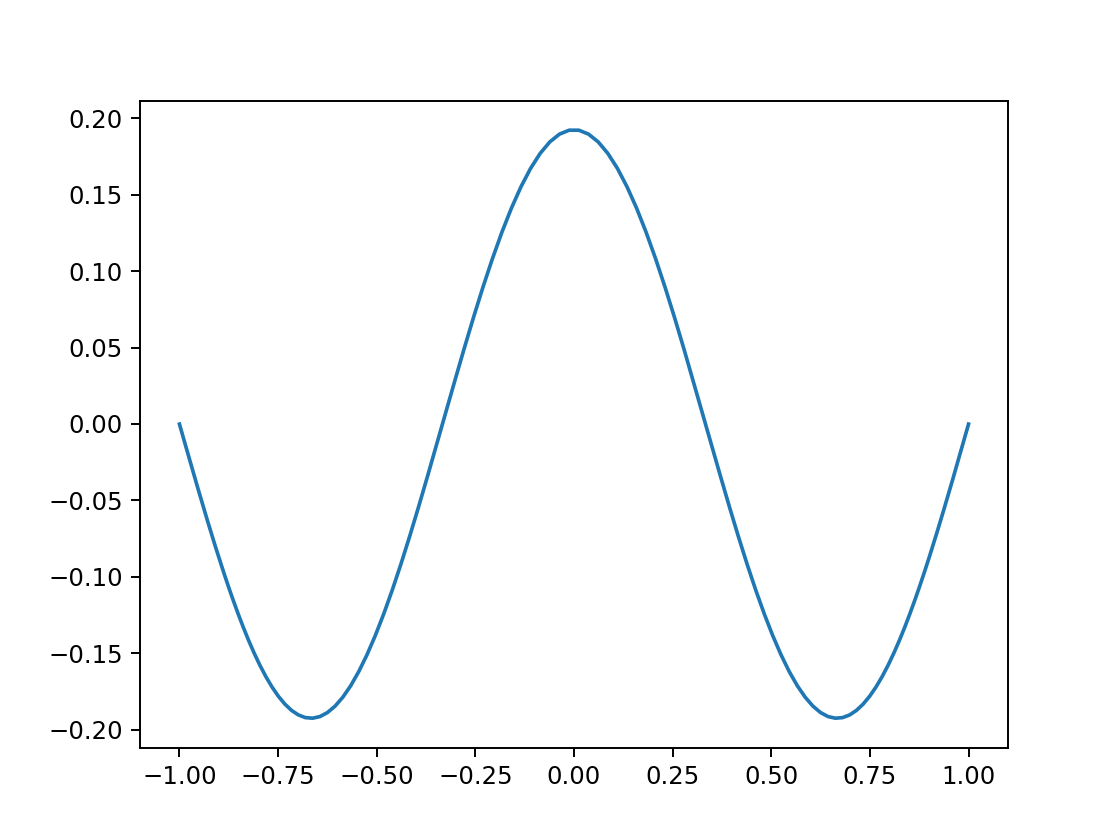

/opt/miniconda3/envs/dedalus_new/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [59]:
u.require_grid_space()
plt.figure()
plt.plot(x, u.data)

Eigenvalues:

<IPython.core.display.Javascript object>


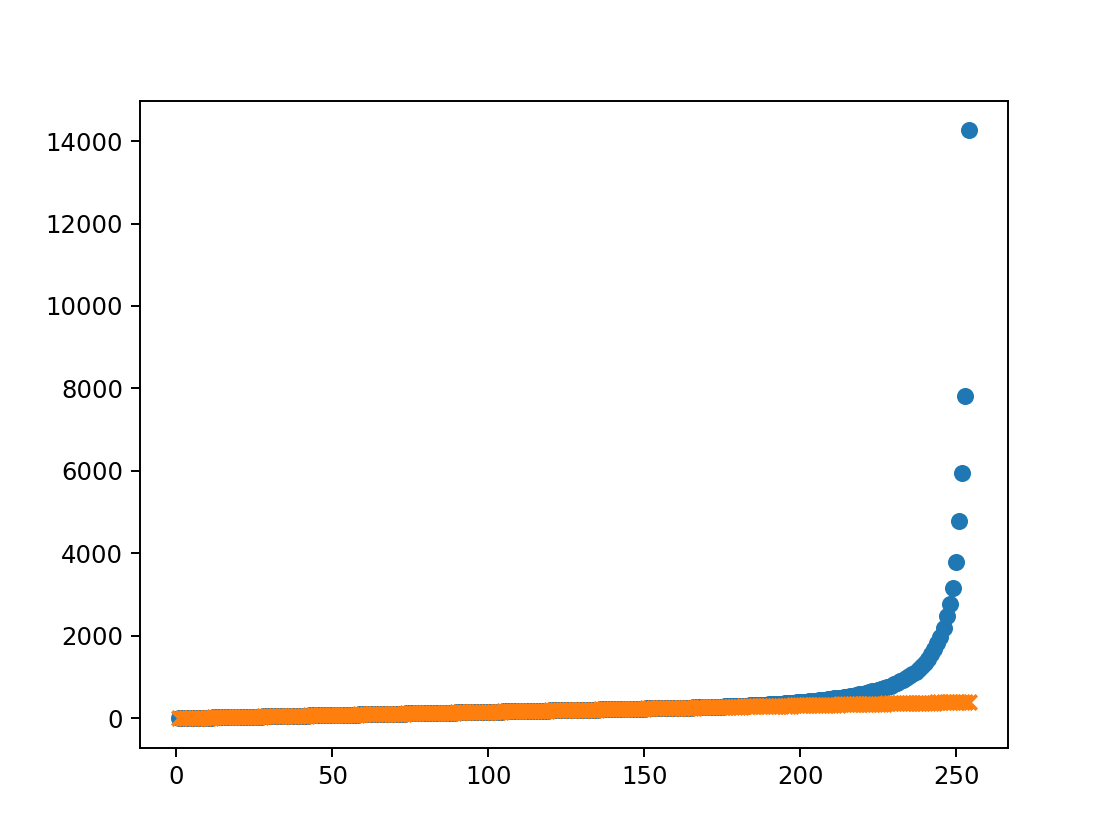

/opt/miniconda3/envs/dedalus_new/lib/python3.8/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


In [71]:
i = np.arange(len(om))+1
plt.figure()
plt.scatter(i, om)
plt.scatter(i, np.pi/2*i, marker='x')

In [39]:
i

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

<IPython.core.display.Javascript object>


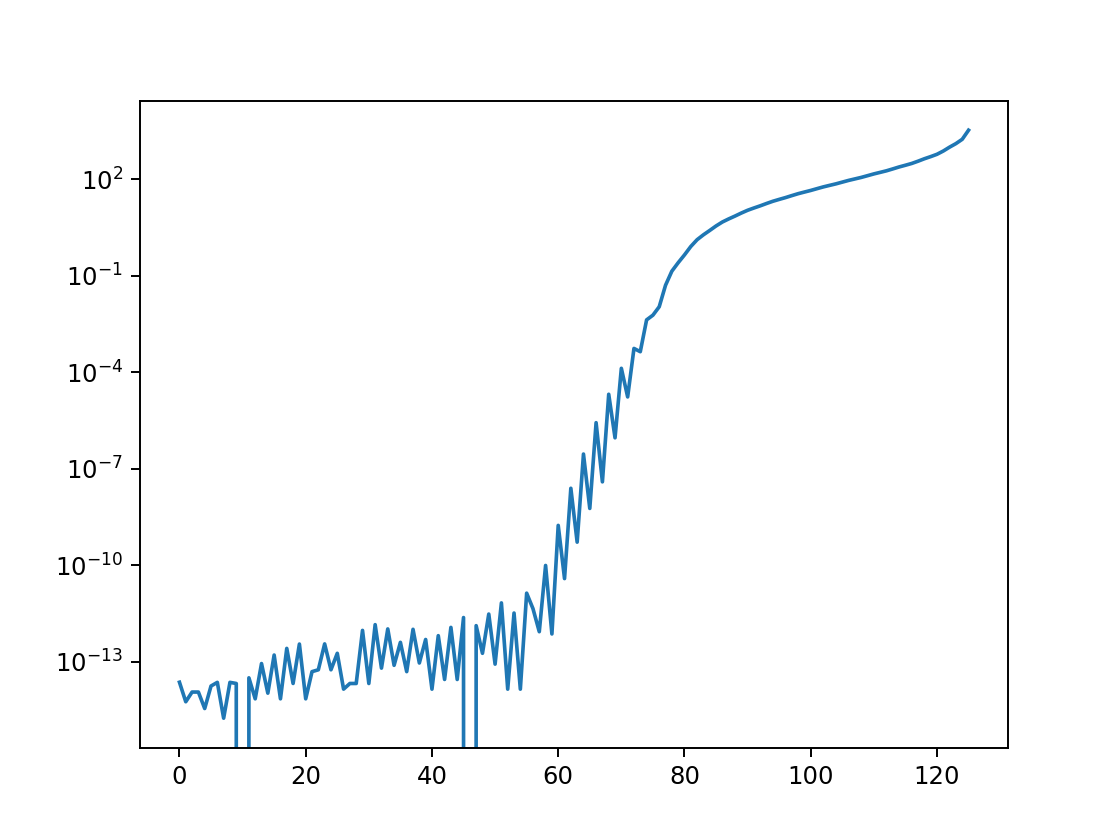

In [61]:
error = np.abs(om - np.pi/2*i)
plt.figure()
plt.plot(error)
plt.yscale('log')

Rule of thumb:
 - about half eigenvalues will be accurate (well-resolved)
 - other half will be unaccurate